In [58]:
import pandas as pd

In [59]:
data_size = str(100)
system = 'rdflib'

In [60]:
sparql_times = f"/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix/results/{system}/{data_size}/times.csv"
n3_times = f"/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix/n3/results/{data_size}/times.csv"

In [61]:
df_sparql = pd.read_csv(sparql_times)
df_sparql['nr'] = df_sparql['query'].str.slice(len("query-"), -len(".sparql"))
df_sparql['total_time'] = df_sparql['load_time'] + df_sparql['exec_time']
df_sparql

,query,data,load_time,exec_time,nr,total_time
0,query-0.sparql,data_100.nt,4.235792,69.017417,0,73.253209
1,query-1.sparql,data_100.nt,3.369750,75.526250,1,78.896000
2,query-10.sparql,data_100.nt,1.570000,27.148791,10,28.718791
3,query-11.sparql,data_100.nt,1.270833,254.549625,11,255.820458
4,query-12.sparql,data_100.nt,1.789208,14598.594333,12,14600.383541
5,query-13.sparql,data_100.nt,1.679750,32.538375,13,34.218125
6,query-14.sparql,data_100.nt,1.632041,270.593000,14,272.225041
7,query-15.sparql,data_100.nt,1.702208,5.953542,15,7.655750
8,query-16.sparql,data_100.nt,1.425792,995.510333,16,996.936125
9,query-17.sparql,data_100.nt,1.811042,37.288833,17,39.099875


In [62]:
df_n3 = pd.read_csv(n3_times)
# df_n3['total_time'] = df_n3['netw_time'] + df_n3['reas_time']
df_n3['nr'] = df_n3['query'].str.slice(len("query-"), -len(".n3"))
df_n3['id'] = df_n3.apply(lambda x: f"{x['query']},{x['type']}", axis=1)

df_n3

,query,data,type,phase,netw_time,reas_time,nr,id
0,query-0.n3,data_100.nt,fwd,create,16,51,0,"query-0.n3,fwd"
1,query-0.n3,data_100.nt,fwd,run,18,17,0,"query-0.n3,fwd"
2,query-0.n3,data_100.nt,fwd,total,34,68,0,"query-0.n3,fwd"
3,query-1.n3,data_100.nt,fwd,create,16,61,1,"query-1.n3,fwd"
4,query-1.n3,data_100.nt,fwd,run,17,14,1,"query-1.n3,fwd"
...,...,...,...,...,...,...,...,...
142,query-8.n3,data_100.nt,fwd,run,20,527,8,"query-8.n3,fwd"
143,query-8.n3,data_100.nt,fwd,total,36,593,8,"query-8.n3,fwd"
144,query-9.n3,data_100.nt,fwd,create,16,40,9,"query-9.n3,fwd"
145,query-9.n3,data_100.nt,fwd,run,13,4,9,"query-9.n3,fwd"


In [63]:
df_n3_failed = df_n3[df_n3['reas_time']==-1]['id']
df_n3_failed

121    query-45.n3,fwd
Name: id, dtype: object

In [64]:
df_n3_filt = df_n3[~df_n3['id'].isin(df_n3_failed)]
df_n3_filt

,query,data,type,phase,netw_time,reas_time,nr,id
0,query-0.n3,data_100.nt,fwd,create,16,51,0,"query-0.n3,fwd"
1,query-0.n3,data_100.nt,fwd,run,18,17,0,"query-0.n3,fwd"
2,query-0.n3,data_100.nt,fwd,total,34,68,0,"query-0.n3,fwd"
3,query-1.n3,data_100.nt,fwd,create,16,61,1,"query-1.n3,fwd"
4,query-1.n3,data_100.nt,fwd,run,17,14,1,"query-1.n3,fwd"
...,...,...,...,...,...,...,...,...
142,query-8.n3,data_100.nt,fwd,run,20,527,8,"query-8.n3,fwd"
143,query-8.n3,data_100.nt,fwd,total,36,593,8,"query-8.n3,fwd"
144,query-9.n3,data_100.nt,fwd,create,16,40,9,"query-9.n3,fwd"
145,query-9.n3,data_100.nt,fwd,run,13,4,9,"query-9.n3,fwd"


In [65]:
df_n3_total = df_n3_filt[df_n3_filt['phase'].isna() | (df_n3_filt['phase']=='total')]
df_n3_total

,query,data,type,phase,netw_time,reas_time,nr,id
2,query-0.n3,data_100.nt,fwd,total,34,68,0,"query-0.n3,fwd"
5,query-1.n3,data_100.nt,fwd,total,33,75,1,"query-1.n3,fwd"
8,query-10.n3,data_100.nt,fwd,total,34,69,10,"query-10.n3,fwd"
11,query-11.n3,data_100.nt,fwd,total,31,84,11,"query-11.n3,fwd"
14,query-12.n3,data_100.nt,fwd,total,33,225,12,"query-12.n3,fwd"
17,query-13.n3,data_100.nt,fwd,total,30,41,13,"query-13.n3,fwd"
20,query-14.n3,data_100.nt,fwd,total,30,100,14,"query-14.n3,fwd"
23,query-15.n3,data_100.nt,fwd,total,28,25,15,"query-15.n3,fwd"
26,query-16.n3,data_100.nt,fwd,total,34,581,16,"query-16.n3,fwd"
29,query-17.n3,data_100.nt,fwd,total,32,53,17,"query-17.n3,fwd"


<AxesSubplot: xlabel='nr'>

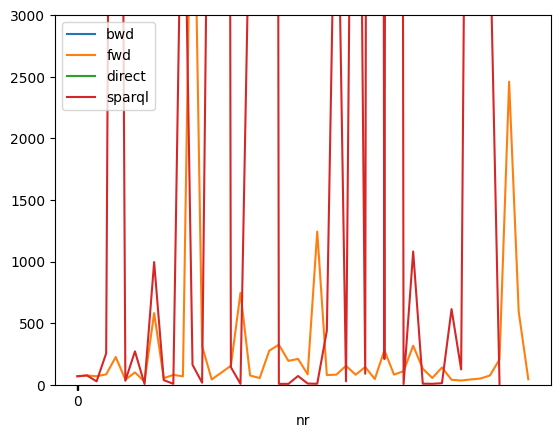

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_ylim(0, 3000)

df_n3_bwd = df_n3_total[df_n3_total['type']=='bwd']
df_n3_bwd.plot(x='nr', y='reas_time', ax=ax, label='bwd')

df_n3_fwd = df_n3_total[df_n3_total['type']=='fwd']
df_n3_fwd.plot(x='nr', y='reas_time', ax=ax, label='fwd')

df_n3_direct = df_n3_total[df_n3_total['type']=='direct']
df_n3_direct.plot(x='nr', y='reas_time', ax=ax, label='direct')

df_sparql.plot(x='nr', y='exec_time', ax=ax, label='sparql')

In [67]:
df_n3_fwd

,query,data,type,phase,netw_time,reas_time,nr,id
2,query-0.n3,data_100.nt,fwd,total,34,68,0,"query-0.n3,fwd"
5,query-1.n3,data_100.nt,fwd,total,33,75,1,"query-1.n3,fwd"
8,query-10.n3,data_100.nt,fwd,total,34,69,10,"query-10.n3,fwd"
11,query-11.n3,data_100.nt,fwd,total,31,84,11,"query-11.n3,fwd"
14,query-12.n3,data_100.nt,fwd,total,33,225,12,"query-12.n3,fwd"
17,query-13.n3,data_100.nt,fwd,total,30,41,13,"query-13.n3,fwd"
20,query-14.n3,data_100.nt,fwd,total,30,100,14,"query-14.n3,fwd"
23,query-15.n3,data_100.nt,fwd,total,28,25,15,"query-15.n3,fwd"
26,query-16.n3,data_100.nt,fwd,total,34,581,16,"query-16.n3,fwd"
29,query-17.n3,data_100.nt,fwd,total,32,53,17,"query-17.n3,fwd"


<AxesSubplot: xlabel='nr'>

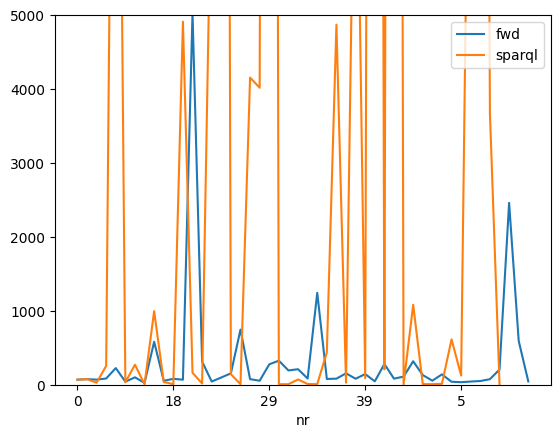

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_ylim(0, 5000)

df_n3_fwd = df_n3_total[df_n3_total['type']=='fwd']
df_n3_fwd.plot(x='nr', y='reas_time', ax=ax, label='fwd')

df_sparql.plot(x='nr', y='exec_time', ax=ax, label='sparql')

In [69]:
df_n3_fwd['reas_time'].describe()

count      48.000000
mean      324.041667
std       798.191679
min        25.000000
25%        64.750000
50%        84.000000
75%       213.750000
max      5027.000000
Name: reas_time, dtype: float64

In [70]:
df_sparql['exec_time'].describe()

count       45.000000
mean      6353.249029
std      13924.993075
min          5.868917
25%         12.512292
50%        142.061667
75%       4154.744375
max      50717.193459
Name: exec_time, dtype: float64

In [71]:
df_sparql.sort_values('exec_time', ascending=False)

,query,data,load_time,exec_time,nr,total_time
33,query-41.sparql,data_100.nt,1.483667,50717.193459,41,50718.677126
20,query-29.sparql,data_100.nt,1.624542,50563.591333,29,50565.215875
31,query-4.sparql,data_100.nt,1.444625,45082.409750,4,45083.854375
15,query-24.sparql,data_100.nt,1.545625,41379.133333,24,41380.678958
42,query-7.sparql,data_100.nt,1.648958,30327.099042,7,30328.748000
4,query-12.sparql,data_100.nt,1.789208,14598.594333,12,14600.383541
41,query-6.sparql,data_100.nt,1.562250,10504.575708,6,10506.137958
29,query-38.sparql,data_100.nt,1.320833,8963.059542,38,8964.380375
14,query-23.sparql,data_100.nt,1.357708,7305.773208,23,7307.130916
11,query-19.sparql,data_100.nt,1.321292,4911.676875,19,4912.998167
